#**Forecasting Wind Energy Production & Demand in Ireland based on Weather and Installed Capacity**

> Indented block



## **Importing Libraries**

In [ ]:
# Data manipulation
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')
import seaborn as sns


# Modelling and Forecasting
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
#from skforecast.ForecasterAutoreg import ForecasterAutoreg
#from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
#from skforecast.model_selection import grid_search_forecaster
#from skforecast.model_selection import backtesting_forecaster
from datetime import datetime


# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Use white grid plot background from seaborn
sns.set(font_scale=1.5, style="whitegrid")

# Connect with Google Drive
from google.colab import drive
drive.mount('/content/drive')

import io
import requests

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from datetime import tzinfo, timedelta, datetime, date


# Warnings configuration
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive


##**Dataset 1: Energy Production**

In [ ]:
# Importing the Dataset1 - Energy Production
df1 = pd.read_csv('/content/drive/MyDrive/Energy_Project/Energy Production_clean.csv')
df1 = df1.drop(columns=['Start Time', 'Fossil Gas  - Actual Aggregated [MW]', 'Fossil Hard coal  - Actual Aggregated [MW]', 'Fossil Oil  - Actual Aggregated [MW]', 'Fossil Peat  - Actual Aggregated [MW]', 'Hydro Pumped Storage  - Actual Aggregated [MW]', 'Hydro Pumped Storage  - Actual Consumption [MW]', 'Hydro Run-of-river and poundage  - Actual Aggregated [MW]', 'Other  - Actual Aggregated [MW]'])
print(df1.shape)
df1.head()

(122750, 3)


,Area,End Time,Wind Onshore - Actual Aggregated [MW]
0,Ireland (IE),01.01.2015 00:30,NaN
1,Ireland (IE),01.01.2015 01:00,NaN
2,Ireland (IE),01.01.2015 01:30,1287.0
3,Ireland (IE),01.01.2015 02:00,1336.0
4,Ireland (IE),01.01.2015 02:30,1290.0


In [ ]:
df1.head()

,Area,End Time,Wind Onshore - Actual Aggregated [MW]
0,Ireland (IE),01.01.2015 00:30,NaN
1,Ireland (IE),01.01.2015 01:00,NaN
2,Ireland (IE),01.01.2015 01:30,1287.0
3,Ireland (IE),01.01.2015 02:00,1336.0
4,Ireland (IE),01.01.2015 02:30,1290.0


In [ ]:
df1.isnull().sum()


Area                                        0
End Time                                    0
Wind Onshore  - Actual Aggregated [MW]    558
dtype: int64

In [ ]:
#Filling missing values with Linear Interpolation
df1['Wind Onshore  - Actual Aggregated [MW]'] = df1['Wind Onshore  - Actual Aggregated [MW]'].interpolate(method='linear', limit_direction='forward', axis=0)

df1.isnull().sum()


Area                                      0
End Time                                  0
Wind Onshore  - Actual Aggregated [MW]    2
dtype: int64

In [ ]:
df1.head()

,Area,End Time,Wind Onshore - Actual Aggregated [MW]
0,Ireland (IE),01.01.2015 00:30,NaN
1,Ireland (IE),01.01.2015 01:00,NaN
2,Ireland (IE),01.01.2015 01:30,1287.0
3,Ireland (IE),01.01.2015 02:00,1336.0
4,Ireland (IE),01.01.2015 02:30,1290.0


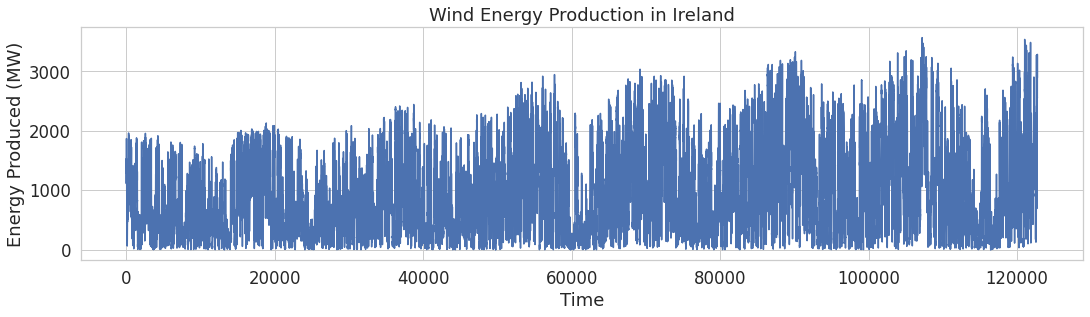

In [ ]:
df1['Wind Onshore  - Actual Aggregated [MW]'].plot(figsize=(16,4),legend=False)
plt.title('Wind Energy Production in Ireland')
plt.xlabel('Time')
plt.ylabel('Energy Produced (MW)')

plt.show()

#for col in df.columns:
#    print(col)

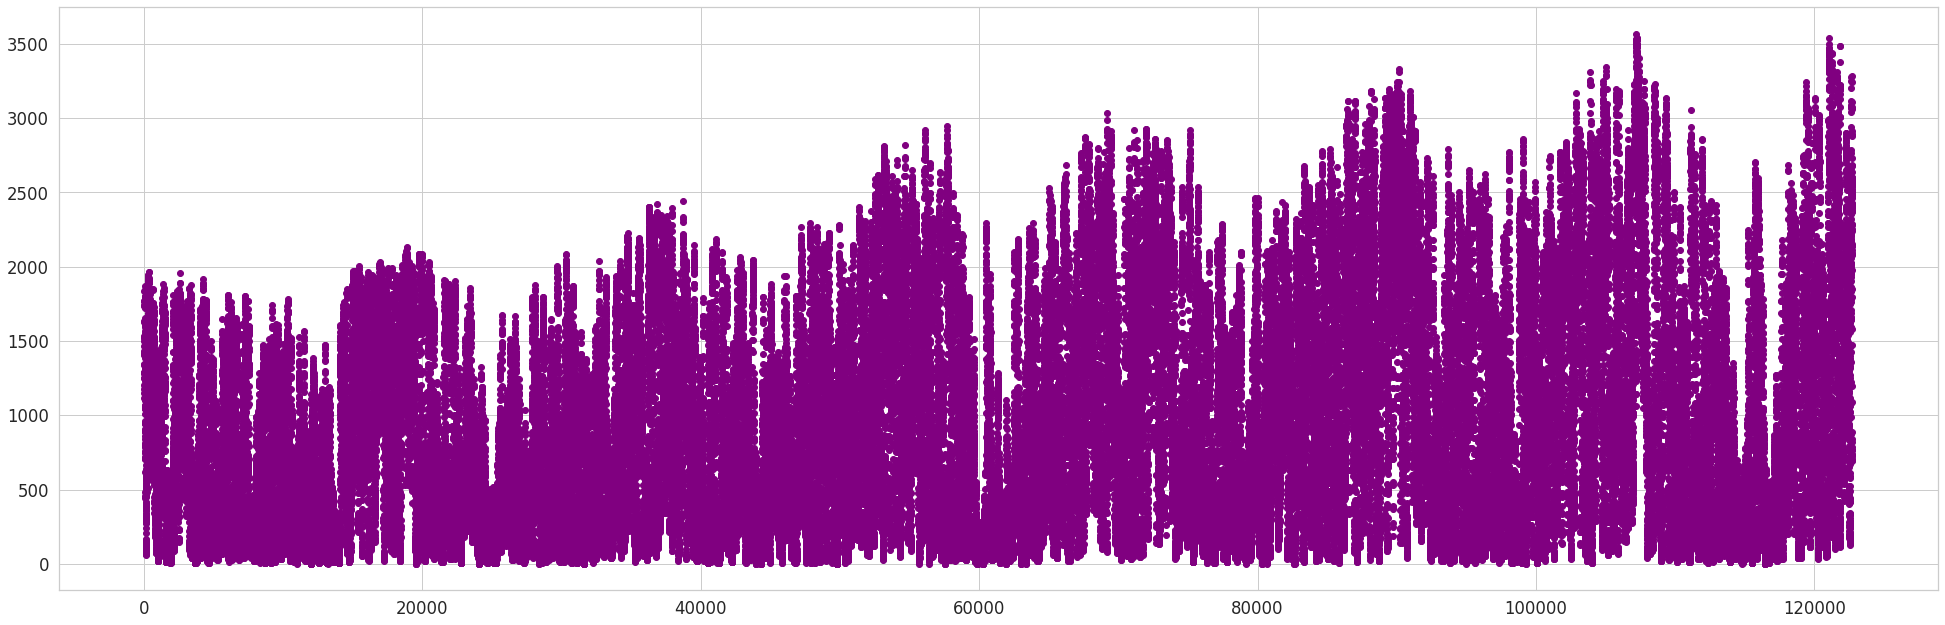

In [ ]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(30, 10))

# Add x-axis and y-axis
ax.scatter(df1.index.values,
           df1['Wind Onshore  - Actual Aggregated [MW]'],
           color='purple')

In [ ]:
df1['End Time'] = pd.to_datetime(df1['End Time'], infer_datetime_format=True)
df1_resampled = df1.set_index('End Time')
df1_daily = df1_resampled.resample('D').mean().reset_index()
df1_daily

,End Time,Wind Onshore - Actual Aggregated [MW]
0,2015-01-01,1558.488889
1,2015-01-02,532.979167
2,2015-01-03,1244.979167
3,2015-01-04,1191.000000
4,2015-01-05,836.458333
...,...,...
2553,2021-12-28,753.520833
2554,2021-12-29,2371.854167
2555,2021-12-30,1485.125000
2556,2021-12-31,2541.333333


In [ ]:
df1_daily = df1.set_index('End Time')
df1_monthly = df1_daily.resample('M').mean().reset_index()
df1_monthly

,End Time,Wind Onshore - Actual Aggregated [MW]
0,2015-01-31,897.938721
1,2015-02-28,904.386905
2,2015-03-31,637.256720
3,2015-04-30,585.856250
4,2015-05-31,731.018145
...,...,...
80,2021-09-30,1026.671528
81,2021-10-31,1201.556331
82,2021-11-30,1352.014457
83,2021-12-31,1393.338204


In [ ]:
df1_monthly['Year'] = pd.DatetimeIndex(df1_monthly['End Time']).year
df1_monthly['Month'] = pd.DatetimeIndex(df1_monthly['End Time']).month

In [ ]:
df1_monthly.head()

,End Time,Wind Onshore - Actual Aggregated [MW],Year,Month
0,2015-01-31,897.938721,2015,1
1,2015-02-28,904.386905,2015,2
2,2015-03-31,637.256720,2015,3
3,2015-04-30,585.856250,2015,4
4,2015-05-31,731.018145,2015,5


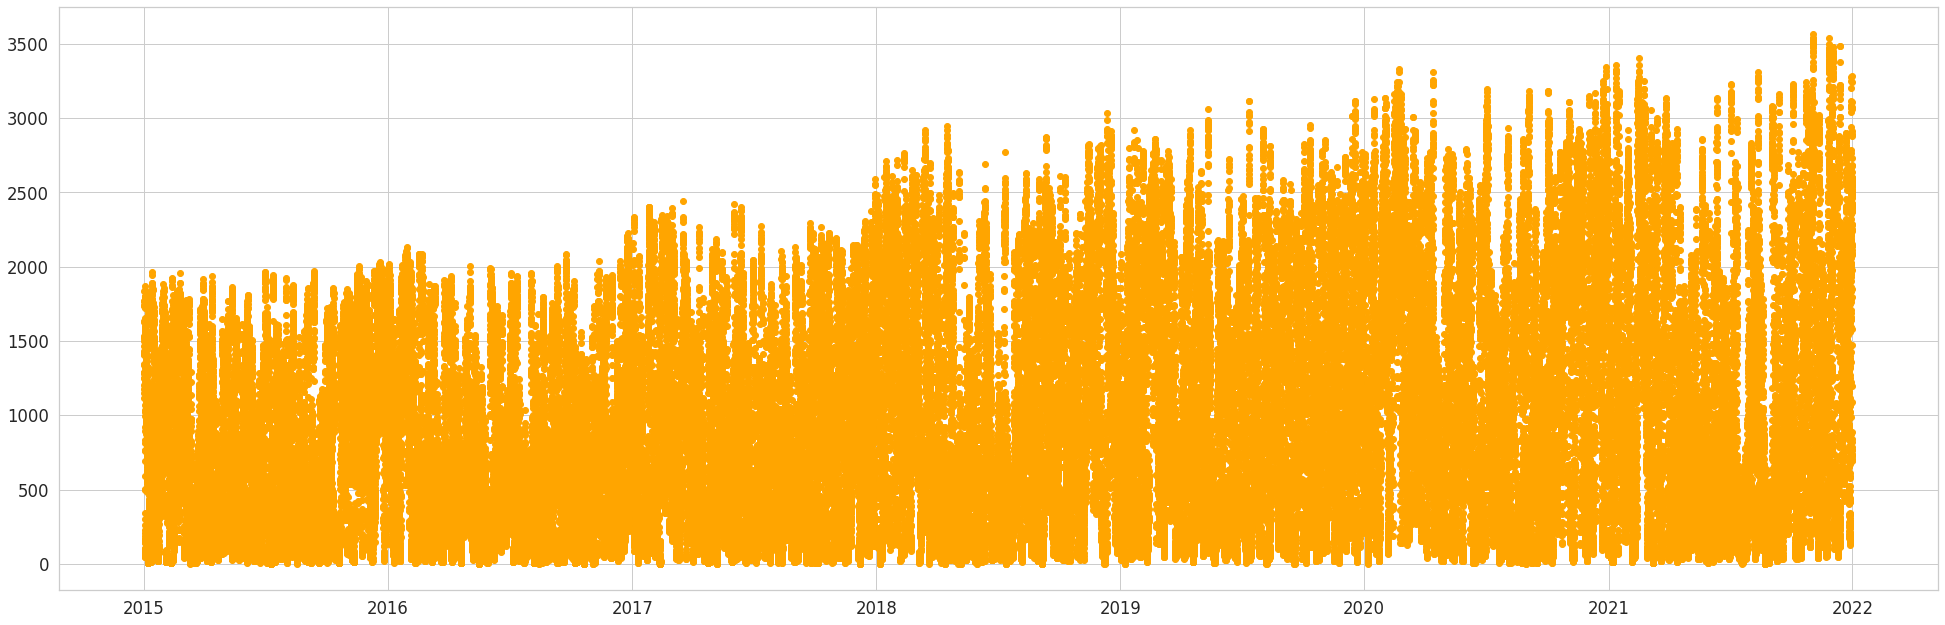

In [ ]:
##DAILY
# Create figure and plot space
fig, ax = plt.subplots(figsize=(30, 10))

# Add x-axis and y-axis
ax.scatter(df1_daily.index.values,
           df1_daily['Wind Onshore  - Actual Aggregated [MW]'],
           color='orange')

In [ ]:
df1_monthly.columns

Index(['End Time', 'Wind Onshore  - Actual Aggregated [MW]', 'Year', 'Month'], dtype='object')

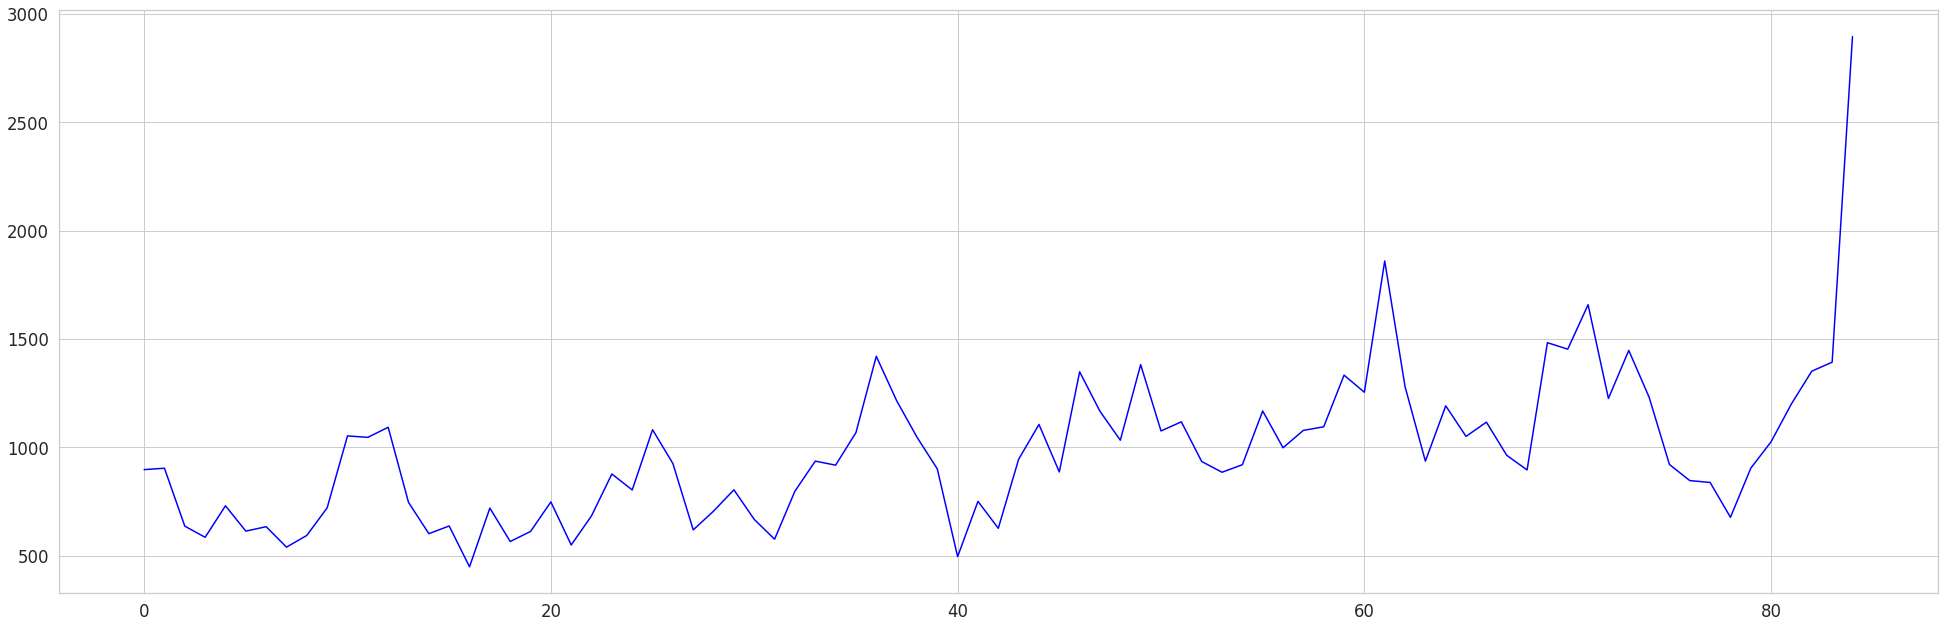

In [ ]:
##MONTHLY
# Create figure and plot space
fig, ax = plt.subplots(figsize=(30, 10))

# Add x-axis and y-axis
ax.plot(df1_monthly.index.values,
           df1_monthly['Wind Onshore  - Actual Aggregated [MW]'],
           color='blue')

In [ ]:
df1_monthly

,End Time,Wind Onshore - Actual Aggregated [MW],Year,Month
0,2015-01-31,897.938721,2015,1
1,2015-02-28,904.386905,2015,2
2,2015-03-31,637.256720,2015,3
3,2015-04-30,585.856250,2015,4
4,2015-05-31,731.018145,2015,5
...,...,...,...,...
80,2021-09-30,1026.671528,2021,9
81,2021-10-31,1201.556331,2021,10
82,2021-11-30,1352.014457,2021,11
83,2021-12-31,1393.338204,2021,12


##**Dataset 2: Energy Demand**

In [ ]:
#importing Dataset2 - Energy Demand
df2 = pd.read_csv('/content/drive/MyDrive/Energy_Project/Energy_Total_Load_Day-Ahead_Ireland_2015-22.csv')
print(df2.shape)
df2.head()

(122750, 4)


,Time_Start,Time_End,Day-ahead Total Load Forecast [MW] - Ireland (IE),Actual Total Load [MW] - Ireland (IE)
0,01.01.2015 00:00,01.01.2015 00:30,NaN,NaN
1,01.01.2015 00:30,01.01.2015 01:00,NaN,NaN
2,01.01.2015 01:00,01.01.2015 01:30,3616.0,2903.0
3,01.01.2015 01:30,01.01.2015 02:00,3550.0,2832.0
4,01.01.2015 02:00,01.01.2015 02:30,3403.0,2726.0


In [ ]:
df2.describe()

,Day-ahead Total Load Forecast [MW] - Ireland (IE),Actual Total Load [MW] - Ireland (IE)
count,121198.000000,121670.000000
mean,3344.118071,3251.732835
std,683.921254,626.097790
min,1758.000000,1766.000000
25%,2787.000000,2744.000000
50%,3415.000000,3309.000000
75%,3849.000000,3706.000000
max,5537.000000,5363.000000


In [ ]:
df2.isnull().sum()

Time_Start                                              0
Time_End                                                0
Day-ahead Total Load Forecast [MW] - Ireland (IE)    1552
Actual Total Load [MW] - Ireland (IE)                1080
dtype: int64

In [ ]:

for col in df2.columns:
    print(col)

Time_Start
Time_End
Day-ahead Total Load Forecast [MW] - Ireland (IE)
Actual Total Load [MW] - Ireland (IE)


In [ ]:
df2['Time_End'] = pd.to_datetime(df2['Time_End'])
df2 = df2.drop(columns='Time_Start')
df2 = df2.set_index('Time_End')

In [ ]:
df2['Actual Total Load [MW] - Ireland (IE)'] = df2['Actual Total Load [MW] - Ireland (IE)'].interpolate(method='linear', limit_direction='forward', axis=0)

df2.isnull().sum()

Day-ahead Total Load Forecast [MW] - Ireland (IE)    1552
Actual Total Load [MW] - Ireland (IE)                   2
dtype: int64

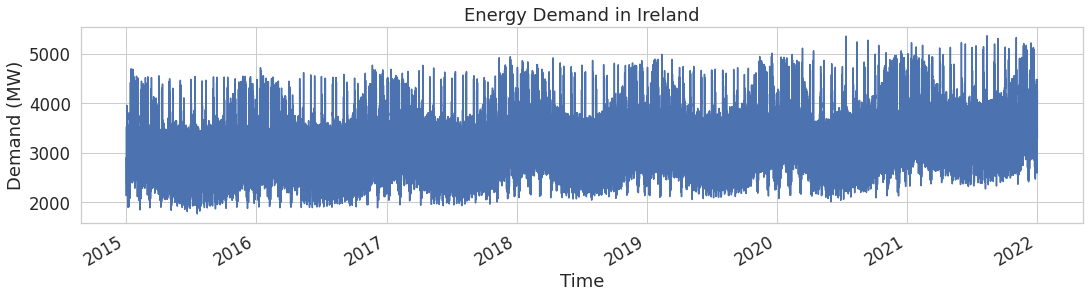

In [ ]:
df2['Actual Total Load [MW] - Ireland (IE)'].plot(figsize=(16,4),legend=False)

plt.title('Energy Demand in Ireland')
plt.xlabel('Time')
plt.ylabel('Demand (MW)')

plt.show()

##**Dataset 3: Installed Wind Capacity**



In [ ]:
#importing Dataset3 - Installed Wind Capacity
df3 = pd.read_csv('/content/drive/MyDrive/Energy_Project/Installed_Wind_Capacity.csv')
df3.head()

,YYYY,Mon,Date,Ireland TSO,Ireland DSO,Ireland Total,NI TSO,NI DSO,NI Total,All Island Total
0,2015,Jan,01/01/2015,"1,046.55","1,231.37","2,277.92",73.6,NaN,NaN,NaN
1,2015,Feb,01/02/2015,"1,046.55","1,232.37","2,278.92",73.6,NaN,NaN,NaN
2,2015,Mar,01/03/2015,"1,046.55","1,232.37","2,278.92",73.6,NaN,NaN,NaN
3,2015,Apr,01/04/2015,"1,046.55","1,232.37","2,278.92",73.6,NaN,NaN,NaN
4,2015,May,01/05/2015,"1,051.55","1,282.27","2,333.82",73.6,NaN,NaN,NaN


In [ ]:
df3['Month'] = pd.DatetimeIndex(df3['Date']).month

In [ ]:
df3.head()

,YYYY,Mon,Date,Ireland TSO,Ireland DSO,Ireland Total,NI TSO,NI DSO,NI Total,All Island Total,Month
0,2015,Jan,01/01/2015,"1,046.55","1,231.37","2,277.92",73.6,NaN,NaN,NaN,1
1,2015,Feb,01/02/2015,"1,046.55","1,232.37","2,278.92",73.6,NaN,NaN,NaN,1
2,2015,Mar,01/03/2015,"1,046.55","1,232.37","2,278.92",73.6,NaN,NaN,NaN,1
3,2015,Apr,01/04/2015,"1,046.55","1,232.37","2,278.92",73.6,NaN,NaN,NaN,1
4,2015,May,01/05/2015,"1,051.55","1,282.27","2,333.82",73.6,NaN,NaN,NaN,1


In [ ]:
df3.describe()

,YYYY,NI TSO,Month
count,86.000000,84.000000,86.0
mean,2018.093023,103.570238,1.0
std,2.078619,23.058641,0.0
min,2015.000000,73.600000,1.0
25%,2016.000000,73.600000,1.0
50%,2018.000000,121.100000,1.0
75%,2020.000000,121.100000,1.0
max,2022.000000,121.100000,1.0


In [ ]:
#df3.drop(index=df3.index[-2:])

In [ ]:
df3.isnull().sum()

YYYY                 0
Mon                  0
Date                 0
Ireland TSO          0
Ireland DSO          2
Ireland Total        2
NI TSO               2
NI DSO              85
NI Total            85
All Island Total    85
Month                0
dtype: int64

In [ ]:
for col in df3.columns:
    print(col)

YYYY
Mon
Date
Ireland TSO
Ireland DSO
Ireland Total
NI TSO
NI DSO
NI Total
All Island Total
Month


In [ ]:
df3["Date"]=pd.to_datetime(df3["Date"], format='%d/%m/%Y')
df3['Year'] = pd.DatetimeIndex(df3["Date"]).year
df3['Month'] = pd.DatetimeIndex(df3["Date"]).month
df3['Ireland Total']= df3['Ireland Total'].str.replace(',', '').astype(float)

In [ ]:
# df3['All Island Total'] = df3['All Island Total'].interpolate(method='linear', limit_direction='forward', axis=0)
# df3['Ireland Total'] = df3['Ireland Total'].interpolate(method='linear', limit_direction='forward', axis=0)
dff_capacity = df3.drop(columns=['Ireland TSO', 'Ireland DSO', 'NI TSO', 'NI DSO'])
dff_capacity['All Island Total'] = df3['All Island Total'].bfill()
dff_capacity['Ireland Total'] = df3['Ireland Total'].bfill()
dff_capacity['NI Total'] = df3['NI Total'].bfill()

dff_capacity.isnull().sum()

YYYY                0
Mon                 0
Date                0
Ireland Total       2
NI Total            2
All Island Total    2
Month               0
Year                0
dtype: int64

In [ ]:
dff_capacity.dropna(inplace=True)
dff_capacity.isnull().sum()

YYYY                0
Mon                 0
Date                0
Ireland Total       0
NI Total            0
All Island Total    0
Month               0
Year                0
dtype: int64

In [ ]:
dff_capacity.head()

,YYYY,Mon,Date,Ireland Total,NI Total,All Island Total,Month,Year
0,2015,Jan,2015-01-01,2277.92,"1,350.60","5,683.09",1,2015
1,2015,Feb,2015-02-01,2278.92,"1,350.60","5,683.09",2,2015
2,2015,Mar,2015-03-01,2278.92,"1,350.60","5,683.09",3,2015
3,2015,Apr,2015-04-01,2278.92,"1,350.60","5,683.09",4,2015
4,2015,May,2015-05-01,2333.82,"1,350.60","5,683.09",5,2015


In [ ]:
# dff_capacity['Date'] = pd.to_datetime(dff_capacity['Date'], infer_datetime_format=True)
# dff_capacity = dff_capacity.set_index('Date')
# # dff_capacity_monthly = dff_capacity.resample('M').sum()
# dff_capacity

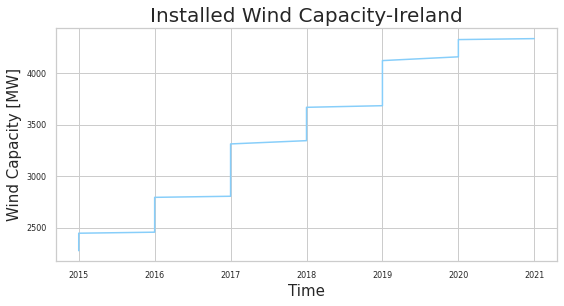

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(dff_capacity['YYYY'], dff_capacity['Ireland Total'], color="lightskyblue")
plt.title('Installed Wind Capacity-Ireland', fontsize=20)
plt.xticks(fontsize= 8)
plt.yticks(fontsize= 8)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Wind Capacity [MW]', fontsize=15)

plt.show()

In [ ]:
capacity_production_df = pd.merge(df3, df1_monthly, on=['Year', 'Month'], how='left')


In [ ]:
capacity_production_df

In [ ]:
plt.plot(df3['year'], df3['Ireland Total'], color= 'orange', label = "Installed Wind Capacity", linestyle="-")
plt.plot (df1_monthly.index.values, df1_monthly['Wind Onshore  - Actual Aggregated [MW]'], color='blue', label = "Energy Production", linestyle="--")
plt.legend()
plt.show()

In [ ]:
#weather_energy =  energy.merge(weather,on='day')

##**Dataset 4: Weather**

In [ ]:
#DUBLIN
#to fill missing values for weather data, use bfill or ffill
df_dublin = pd.read_csv('/content/drive/MyDrive/Energy_Project/532_dublin_airport.csv')
df_dublin.date = pd.to_datetime(df_dublin.date, infer_datetime_format=True, errors='ignore')
# fix space value
df_dublin.wdsp.replace(to_replace= ' ', value=0, inplace=True)
df_dublin.wdsp = df_dublin.wdsp.astype('int32')
df_dublin.head()

In [ ]:
dff_dublin = df_dublin.drop(columns=['Unnamed: 0', 'ind', 'rain', 'ind.1', 'ind.2', 'wetb', 'dewpt', 'ind.3', 'ind.4', 'ww', 'w', 'sun', 'vis', 'clht', 'clamt'])
dff_dublin

In [ ]:
dff_dublin['wddir'].bfill()

In [ ]:
#CORK
df_cork = pd.read_csv('/content/drive/MyDrive/Energy_Project/3904_cork_airport.csv')
df_cork.date = pd.to_datetime(df_cork.date, infer_datetime_format=True, errors='ignore')
# fix space value
df_cork.wdsp.replace(to_replace= ' ', value=0, inplace=True)
df_cork.wdsp = df_cork.wdsp.astype('int32')
dff_cork = df_cork.drop(columns=['Unnamed: 0', 'ind', 'rain', 'ind.1', 'ind.2', 'wetb', 'dewpt', 'ind.3', 'ind.4', 'ww', 'w', 'sun', 'vis', 'clht', 'clamt'])
dff_cork
#dff_cork.isnull().sum()

In [ ]:
#SHANNON
df_shannon = pd.read_csv('/content/drive/MyDrive/Energy_Project/518_shannon_airport.csv')
df_shannon.date = pd.to_datetime(df_shannon.date, infer_datetime_format=True, errors='ignore')
# fix space value
df_shannon.wdsp.replace(to_replace= ' ', value=0, inplace=True)
df_shannon.wdsp = df_shannon.wdsp.astype('int32')
dff_shannon = df_shannon.drop(columns=['Unnamed: 0', 'ind', 'rain', 'ind.1', 'ind.2', 'wetb', 'dewpt', 'ind.3', 'ind.4', 'ww', 'w', 'sun', 'vis', 'clht', 'clamt'])
dff_shannon
#dff_shannon.isnull().sum()

In [ ]:
#BELMULLET
df_bel = pd.read_csv('/content/drive/MyDrive/Energy_Project/2375_belmullet.csv')
df_bel.date = pd.to_datetime(df_bel.date, infer_datetime_format=True, errors='ignore')
# fix space value
df_bel.wdsp.replace(to_replace= ' ', value=0, inplace=True)
df_bel.wdsp = df_bel.wdsp.astype('int32')
dff_bel = df_bel.drop(columns=['Unnamed: 0', 'ind', 'rain', 'ind.1', 'ind.2', 'wetb', 'dewpt', 'ind.3', 'ind.4', 'ww', 'w', 'sun', 'vis', 'clht', 'clamt'])
dff_bel
#dff_bel.isnull().sum()

In [ ]:
#MALIN HEAD
df_malin = pd.read_csv('/content/drive/MyDrive/Energy_Project/1575_malin_head.csv')
df_malin.date = pd.to_datetime(df_malin.date, infer_datetime_format=True, errors='ignore')
# fix space value
df_malin.wdsp.replace(to_replace= ' ', value=0, inplace=True)
df_malin.wdsp = df_malin.wdsp.astype('int32')
dff_malin = df_malin.drop(columns=['Unnamed: 0', 'ind', 'rain', 'ind.1', 'ind.2', 'wetb', 'dewpt', 'ind.3', 'ind.4', 'ww', 'w', 'sun', 'vis', 'clht', 'clamt'])
dff_malin
#dff_malin.isnull().sum()

In [ ]:
dff_malin['wddir'].interpolate()

In [ ]:
dff_malin.isnull().sum()

In [ ]:
left = dff_bel.set_index(['date']).copy()
right = dff_dublin.set_index(['date'])

weather_df = left.join(right, lsuffix="_BEL", rsuffix="_DUB")

right = dff_shannon.set_index(['date'])
weather_df = weather_df.join(right, lsuffix="", rsuffix="_SHA")

right = dff_cork.set_index(['date'])
weather_df = weather_df.join(right, lsuffix="", rsuffix="_COR")

right = dff_malin.set_index(['date'])
weather_df = weather_df.join(right, lsuffix="", rsuffix="_MAL")

weather_df = weather_df.reset_index()

In [ ]:
weather_df.columns

In [ ]:
weather_df

In [ ]:
sns.boxplot(weather_df['wdsp_BEL'])


In [ ]:
sns.boxplot(weather_df['wdsp'])

In [ ]:
sns.boxplot(weather_df['wdsp_DUB'])


In [ ]:
sns.boxplot(weather_df['wdsp_COR'])


In [ ]:
sns.boxplot(weather_df['wdsp_MAL'])


#Practise

In [ ]:
df1.head()


In [ ]:
df2.head()

In [ ]:
df3.head()